# Anticipez les besoins en consommation de bâtiments - *Notebook exploratoire*

## Mission

Vous travaillez pour la ville de Seattle. Pour atteindre son objectif de ville neutre en émissions de carbone en 2050, votre équipe s’intéresse de près à la consommation et aux émissions des bâtiments non destinés à l’habitation.

Des relevés minutieux ont été effectués par les agents de la ville en 2016. Cependant, ces relevés sont coûteux à obtenir, et à partir de ceux déjà réalisés, vous voulez tenter de prédire les émissions de CO2 et la consommation totale d’énergie de bâtiments non destinés à l’habitation pour lesquels elles n’ont pas encore été mesurées.

Votre prédiction se basera sur les données structurelles des bâtiments (taille et usage des bâtiments, date de construction, situation géographique, ...)

Vous cherchez également à évaluer l’intérêt de l’ENERGY STAR Score pour la prédiction d’émissions, qui est fastidieux à calculer avec l’approche utilisée actuellement par votre équipe. Vous l'intégrerez dans la modélisation et jugerez de son intérêt.

Vous sortez tout juste d’une réunion de brief avec votre équipe. Voici un récapitulatif de votre mission :


1) Réaliser une courte analyse exploratoire.
2) Tester différents modèles de prédiction afin de répondre au mieux à la problématique.

Fais bien attention au traitement des différentes variables, à la fois pour trouver de nouvelles informations (peut-on déduire des choses intéressantes d’une simple adresse ?) et optimiser les performances en appliquant des transformations simples aux variables (normalisation, passage au log, etc.).

Mets en place une évaluation rigoureuse des performances, et optimise les hyperparamètres et le choix d’algorithmes de ML à l’aide d’une validation croisée. Tu testeras au minimum 4 algorithmes de famille différente (par exemple : ElasticNet, SVM, GradientBoosting, RandomForest).

## Analyse exploratoire des datasets et 1er feature engineering

### 1 - Découverte du jeu de données

In [128]:
import numpy as np

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import FuncFormatter
import scipy
from scipy import stats
import scipy.stats as st

import statsmodels
import statsmodels.api as sm
import missingno as msno

import sklearn
from sklearn.experimental import enable_iterative_imputer  # Nécessaire pour activer IterativeImputer
from sklearn.impute import IterativeImputer

from sklearn.impute import KNNImputer
# Encodage des variables catégorielles avant d'utiliser KNNImputer
from category_encoders.ordinal import OrdinalEncoder
from sklearn.preprocessing import LabelEncoder

# pour le centrage et la réduction
from sklearn.preprocessing import StandardScaler
# pour l'ACP
from sklearn.decomposition import PCA

from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix

from sklearn import dummy
from sklearn.dummy import DummyClassifier

from sklearn import linear_model
from sklearn.linear_model import Ridge
from sklearn.linear_model import LogisticRegression

from sklearn.svm import LinearSVC

from sklearn import kernel_ridge

from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier

import tensorflow
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

import timeit

print("numpy version", np.__version__)
print("pandas version", pd.__version__)
print("matplotlib version", matplotlib.__version__)
print("seaborn version", sns.__version__)
print("scipy version", scipy.__version__)
print("statsmodels version", statsmodels.__version__)
print("missingno version", msno.__version__)

print("sklearn version", sklearn.__version__)
print("tensorflow version", tensorflow.__version__)

pd.options.display.max_rows = 200
pd.options.display.max_columns = 100

numpy version 1.26.4
pandas version 2.1.4
matplotlib version 3.8.0
seaborn version 0.13.2
scipy version 1.11.4
statsmodels version 0.14.0
missingno version 0.5.2
sklearn version 1.2.2
tensorflow version 2.18.0


In [103]:
# Charger le fichier de données
data = pd.read_csv("C:/Users/admin/Documents/Projets/Projet_4/data_projet/source/2016_Building_Energy_Benchmarking.csv", sep=',', low_memory=False)
data.head()

,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Address,City,State,ZipCode,TaxParcelIdentificationNumber,CouncilDistrictCode,Neighborhood,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),ListOfAllPropertyUseTypes,LargestPropertyUseType,LargestPropertyUseTypeGFA,SecondLargestPropertyUseType,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseType,ThirdLargestPropertyUseTypeGFA,YearsENERGYSTARCertified,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),DefaultData,Comments,ComplianceStatus,Outlier,TotalGHGEmissions,GHGEmissionsIntensity
0,1,2016,NonResidential,Hotel,Mayflower park hotel,405 Olive way,Seattle,WA,98101.0,0659000030,7,DOWNTOWN,47.61220,-122.33799,1927,1.0,12,88434,0,88434,Hotel,Hotel,88434.0,NaN,NaN,NaN,NaN,NaN,60.0,81.699997,84.300003,182.500000,189.000000,7226362.5,7456910.0,2003882.00,1.156514e+06,3946027.0,12764.52930,1276453.0,False,NaN,Compliant,NaN,249.98,2.83
1,2,2016,NonResidential,Hotel,Paramount Hotel,724 Pine street,Seattle,WA,98101.0,0659000220,7,DOWNTOWN,47.61317,-122.33393,1996,1.0,11,103566,15064,88502,"Hotel, Parking, Restaurant",Hotel,83880.0,Parking,15064.0,Restaurant,4622.0,NaN,61.0,94.800003,97.900002,176.100006,179.399994,8387933.0,8664479.0,0.00,9.504252e+05,3242851.0,51450.81641,5145082.0,False,NaN,Compliant,NaN,295.86,2.86
2,3,2016,NonResidential,Hotel,5673-The Westin Seattle,1900 5th Avenue,Seattle,WA,98101.0,0659000475,7,DOWNTOWN,47.61393,-122.33810,1969,1.0,41,956110,196718,759392,Hotel,Hotel,756493.0,NaN,NaN,NaN,NaN,NaN,43.0,96.000000,97.699997,241.899994,244.100006,72587024.0,73937112.0,21566554.00,1.451544e+07,49526664.0,14938.00000,1493800.0,False,NaN,Compliant,NaN,2089.28,2.19
3,5,2016,NonResidential,Hotel,HOTEL MAX,620 STEWART ST,Seattle,WA,98101.0,0659000640,7,DOWNTOWN,47.61412,-122.33664,1926,1.0,10,61320,0,61320,Hotel,Hotel,61320.0,NaN,NaN,NaN,NaN,NaN,56.0,110.800003,113.300003,216.199997,224.000000,6794584.0,6946800.5,2214446.25,8.115253e+05,2768924.0,18112.13086,1811213.0,False,NaN,Compliant,NaN,286.43,4.67
4,8,2016,NonResidential,Hotel,WARWICK SEATTLE HOTEL (ID8),401 LENORA ST,Seattle,WA,98121.0,0659000970,7,DOWNTOWN,47.61375,-122.34047,1980,1.0,18,175580,62000,113580,"Hotel, Parking, Swimming Pool",Hotel,123445.0,Parking,68009.0,Swimming Pool,0.0,NaN,75.0,114.800003,118.699997,211.399994,215.600006,14172606.0,14656503.0,0.00,1.573449e+06,5368607.0,88039.98438,8803998.0,False,NaN,Compliant,NaN,505.01,2.88


In [6]:
data.shape

(3376, 46)

In [7]:
data.describe()

,OSEBuildingID,DataYear,ZipCode,CouncilDistrictCode,Latitude,Longitude,YearBuilt,NumberofBuildings,NumberofFloors,PropertyGFATotal,PropertyGFAParking,PropertyGFABuilding(s),LargestPropertyUseTypeGFA,SecondLargestPropertyUseTypeGFA,ThirdLargestPropertyUseTypeGFA,ENERGYSTARScore,SiteEUI(kBtu/sf),SiteEUIWN(kBtu/sf),SourceEUI(kBtu/sf),SourceEUIWN(kBtu/sf),SiteEnergyUse(kBtu),SiteEnergyUseWN(kBtu),SteamUse(kBtu),Electricity(kWh),Electricity(kBtu),NaturalGas(therms),NaturalGas(kBtu),Comments,TotalGHGEmissions,GHGEmissionsIntensity
count,3376.000000,3376.0,3360.000000,3376.000000,3376.000000,3376.000000,3376.000000,3368.000000,3376.000000,3.376000e+03,3376.000000,3.376000e+03,3.356000e+03,1679.000000,596.000000,2533.000000,3369.000000,3370.000000,3367.000000,3367.000000,3.371000e+03,3.370000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,3.367000e+03,0.0,3367.000000,3367.000000
mean,21208.991114,2016.0,98116.949107,4.439277,47.624033,-122.334795,1968.573164,1.106888,4.709123,9.483354e+04,8001.526066,8.683201e+04,7.917764e+04,28444.075817,11738.675166,67.918674,54.732116,57.033798,134.232848,137.783932,5.403667e+06,5.276726e+06,2.745959e+05,1.086639e+06,3.707612e+06,1.368505e+04,1.368505e+06,NaN,119.723971,1.175916
std,12223.757015,0.0,18.615205,2.120625,0.047758,0.027203,33.088156,2.108402,5.494465,2.188376e+05,32326.723928,2.079398e+05,2.017034e+05,54392.917928,29331.199286,26.873271,56.273124,57.163330,139.287554,139.109807,2.161063e+07,1.593879e+07,3.912173e+06,4.352478e+06,1.485066e+07,6.709781e+04,6.709781e+06,NaN,538.832227,1.821452
min,1.000000,2016.0,98006.000000,1.000000,47.499170,-122.414250,1900.000000,0.000000,0.000000,1.128500e+04,0.000000,3.636000e+03,5.656000e+03,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-2.100000,0.000000e+00,0.000000e+00,0.000000e+00,-3.382680e+04,-1.154170e+05,0.000000e+00,0.000000e+00,NaN,-0.800000,-0.020000
25%,19990.750000,2016.0,98105.000000,3.000000,47.599860,-122.350662,1948.000000,1.000000,2.000000,2.848700e+04,0.000000,2.775600e+04,2.509475e+04,5000.000000,2239.000000,53.000000,27.900000,29.400000,74.699997,78.400002,9.251286e+05,9.701822e+05,0.000000e+00,1.874229e+05,6.394870e+05,0.000000e+00,0.000000e+00,NaN,9.495000,0.210000
50%,23112.000000,2016.0,98115.000000,4.000000,47.618675,-122.332495,1975.000000,1.000000,4.000000,4.417500e+04,0.000000,4.321600e+04,3.989400e+04,10664.000000,5043.000000,75.000000,38.599998,40.900002,96.199997,101.099998,1.803753e+06,1.904452e+06,0.000000e+00,3.451299e+05,1.177583e+06,3.237538e+03,3.237540e+05,NaN,33.920000,0.610000
75%,25994.250000,2016.0,98122.000000,7.000000,47.657115,-122.319407,1997.000000,1.000000,5.000000,9.099200e+04,0.000000,8.427625e+04,7.620025e+04,26640.000000,10138.750000,90.000000,60.400002,64.275002,143.899994,148.349998,4.222455e+06,4.381429e+06,0.000000e+00,8.293178e+05,2.829632e+06,1.189033e+04,1.189034e+06,NaN,93.940000,1.370000
max,50226.000000,2016.0,98272.000000,7.000000,47.733870,-122.220966,2015.000000,111.000000,99.000000,9.320156e+06,512608.000000,9.320156e+06,9.320156e+06,686750.000000,459748.000000,100.000000,834.400024,834.400024,2620.000000,2620.000000,8.739237e+08,4.716139e+08,1.349435e+08,1.925775e+08,6.570744e+08,2.979090e+06,2.979090e+08,NaN,16870.980000,34.090000


On voit déjà des valeurs aberrantes. Par exemple les valeurs de SourceEUIWN(kBtu/sf) et Electricity(kWh) sont négatives.

In [9]:
list_sort = round(data.isna().mean().sort_values() * 100, 2)
print('Pourcentage de valeurs manquantes par colonne')
list_sort

Pourcentage de valeurs manquantes par colonne


OSEBuildingID                        0.00
PropertyGFABuilding(s)               0.00
PropertyGFAParking                   0.00
PropertyGFATotal                     0.00
NumberofFloors                       0.00
YearBuilt                            0.00
Longitude                            0.00
Latitude                             0.00
Neighborhood                         0.00
DefaultData                          0.00
CouncilDistrictCode                  0.00
ComplianceStatus                     0.00
State                                0.00
City                                 0.00
Address                              0.00
PropertyName                         0.00
PrimaryPropertyType                  0.00
BuildingType                         0.00
DataYear                             0.00
TaxParcelIdentificationNumber        0.00
SiteEnergyUse(kBtu)                  0.15
SiteEnergyUseWN(kBtu)                0.18
SiteEUIWN(kBtu/sf)                   0.18
SiteEUI(kBtu/sf)                  

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    3376 non-null   int64  
 1   DataYear                         3376 non-null   int64  
 2   BuildingType                     3376 non-null   object 
 3   PrimaryPropertyType              3376 non-null   object 
 4   PropertyName                     3376 non-null   object 
 5   Address                          3376 non-null   object 
 6   City                             3376 non-null   object 
 7   State                            3376 non-null   object 
 8   ZipCode                          3360 non-null   float64
 9   TaxParcelIdentificationNumber    3376 non-null   object 
 10  CouncilDistrictCode              3376 non-null   int64  
 11  Neighborhood                     3376 non-null   object 
 12  Latitude            

Pour rappel, il y a 3 376 lignes.

In [12]:
list_sort = round((data == 0).mean().sort_values() * 100, 2)
print('Pourcentage de valeurs = 0 par colonne')
list_sort

Pourcentage de valeurs = 0 par colonne


OSEBuildingID                       0.00
Outlier                             0.00
ComplianceStatus                    0.00
Comments                            0.00
ENERGYSTARScore                     0.00
YearsENERGYSTARCertified            0.00
ThirdLargestPropertyUseType         0.00
SecondLargestPropertyUseType        0.00
LargestPropertyUseType              0.00
ListOfAllPropertyUseTypes           0.00
PropertyGFABuilding(s)              0.00
PropertyGFATotal                    0.00
YearBuilt                           0.00
LargestPropertyUseTypeGFA           0.00
Latitude                            0.00
DataYear                            0.00
BuildingType                        0.00
Neighborhood                        0.00
PrimaryPropertyType                 0.00
CouncilDistrictCode                 0.00
TaxParcelIdentificationNumber       0.00
ZipCode                             0.00
State                               0.00
Longitude                           0.00
City            

In [13]:
list_sort = (data == 0).sum().sort_values()
print('Nombres de valeurs = 0 par colonne')
list_sort

Nombres de valeurs = 0 par colonne


OSEBuildingID                         0
Outlier                               0
ComplianceStatus                      0
Comments                              0
ENERGYSTARScore                       0
YearsENERGYSTARCertified              0
ThirdLargestPropertyUseType           0
SecondLargestPropertyUseType          0
LargestPropertyUseType                0
ListOfAllPropertyUseTypes             0
PropertyGFABuilding(s)                0
PropertyGFATotal                      0
YearBuilt                             0
LargestPropertyUseTypeGFA             0
Latitude                              0
DataYear                              0
BuildingType                          0
Neighborhood                          0
PrimaryPropertyType                   0
CouncilDistrictCode                   0
TaxParcelIdentificationNumber         0
ZipCode                               0
State                                 0
Longitude                             0
City                                  0


In [14]:
data.nunique()

OSEBuildingID                      3376
DataYear                              1
BuildingType                          8
PrimaryPropertyType                  24
PropertyName                       3362
Address                            3354
City                                  1
State                                 1
ZipCode                              55
TaxParcelIdentificationNumber      3268
CouncilDistrictCode                   7
Neighborhood                         19
Latitude                           2876
Longitude                          2656
YearBuilt                           113
NumberofBuildings                    17
NumberofFloors                       50
PropertyGFATotal                   3195
PropertyGFAParking                  496
PropertyGFABuilding(s)             3193
ListOfAllPropertyUseTypes           466
LargestPropertyUseType               56
LargestPropertyUseTypeGFA          3122
SecondLargestPropertyUseType         50
SecondLargestPropertyUseTypeGFA    1352


In [15]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

In [16]:
data['PrimaryPropertyType'].unique()

array(['Hotel', 'Other', 'Mid-Rise Multifamily', 'Mixed Use Property',
       'K-12 School', 'University', 'Small- and Mid-Sized Office',
       'Self-Storage Facility', 'Warehouse', 'Large Office',
       'Senior Care Community', 'Medical Office', 'Retail Store',
       'Hospital', 'Residence Hall', 'Distribution Center',
       'Worship Facility', 'Low-Rise Multifamily',
       'Supermarket / Grocery Store', 'Laboratory',
       'Refrigerated Warehouse', 'Restaurant', 'High-Rise Multifamily',
       'Office'], dtype=object)

In [17]:
data['CouncilDistrictCode'].unique()

array([7, 3, 2, 4, 5, 6, 1], dtype=int64)

In [18]:
data['Neighborhood'].unique()

array(['DOWNTOWN', 'SOUTHEAST', 'NORTHEAST', 'EAST', 'Central', 'NORTH',
       'MAGNOLIA / QUEEN ANNE', 'LAKE UNION', 'GREATER DUWAMISH',
       'BALLARD', 'NORTHWEST', 'CENTRAL', 'SOUTHWEST', 'DELRIDGE',
       'Ballard', 'North', 'Delridge', 'Northwest',
       'DELRIDGE NEIGHBORHOODS'], dtype=object)

In [19]:
data['LargestPropertyUseType'].unique()

array(['Hotel', 'Police Station', 'Other - Entertainment/Public Assembly',
       'Multifamily Housing', 'Library', 'Fitness Center/Health Club/Gym',
       'Social/Meeting Hall', 'Courthouse', 'Other', 'K-12 School',
       'College/University', 'Automobile Dealership', 'Office',
       'Self-Storage Facility', 'Non-Refrigerated Warehouse',
       'Other - Mall', 'Senior Care Community', 'Medical Office',
       'Retail Store', 'Hospital (General Medical & Surgical)', 'Museum',
       'Repair Services (Vehicle, Shoe, Locksmith, etc)',
       'Other - Lodging/Residential', 'Residence Hall/Dormitory',
       'Other/Specialty Hospital', 'Financial Office',
       'Distribution Center', 'Parking', 'Worship Facility', 'Restaurant',
       'Data Center', 'Laboratory', 'Supermarket/Grocery Store',
       'Convention Center', 'Urgent Care/Clinic/Other Outpatient', nan,
       'Other - Services', 'Strip Mall', 'Wholesale Club/Supercenter',
       'Refrigerated Warehouse', 'Manufacturing/Indust

In [20]:
data['Outlier'].unique()

array([nan, 'High outlier', 'Low outlier'], dtype=object)

In [21]:
data['ComplianceStatus'].unique()

array(['Compliant', 'Error - Correct Default Data', 'Missing Data',
       'Non-Compliant'], dtype=object)

On constate:
- Il n'y a qu'une seule année dans le dataset
- Il y a 8 types d'immmeuble (BuildingType)
- Il y a une seule ville : Seattle, dans un seul état
- Il y a 7 districts différents (CouncilDistrictCode)
- Il y a 19 quartiers (Neighborhood), mais certains sont en double, donc 13 réels (nettoyage à prévoir)
- Il y a 55 codes postaux différents (ZipCode)
- Il y a 113 années de construction différentes (yearBuilt)
- Il y a 100 valeurs différentes pour l'ENERGYSTARScore
- Plusieurs batiments ont la même consommation d'energie, et le même taux d'émission de COS
- Quelques bâtiments ont la même adresse
- La feature 'Outlier' ne contient que 2 valeurs : High outlier et Low outlier. Et 99% des valeurs sont manquantes. Elle n'est donc pas utlisable
- La feature 'ComplianceStatus' contient 4 valeurs : Compliant', 'Error - Correct Default Data', 'Missing Data', et 'Non-Compliant'. Toutes les valeurs sont présentes.

In [23]:
data.duplicated().sum()

0

Il n'y a pas de données dupliquées.

### 2 - Choix des variables

#### 2.1 - Sources d'energie

Il y a 3 sources d'energie dans le fichier : electricité, vapeur, gaz naturel.

Il faut choisir les sources exprimées en kBtu pour pouvoir les comparer entre elles, et déterminer la proportion utilisée par bâtiment.

Il s'agit des variables : Electricity(kBtu) , NaturalGas(kBtu), SteamUse(kBtu) 

Ces 3 variables sont assez bien utilisées.

#### 2.2 - Données structurelles

Liste des données structurelles
- PrimaryPropertyType (usage principal) - dans un second temps pour l'amélioration des modèles
- Neighborhood (quartier)
- YearBuilt (année de construction) - créer des périodes (nouvelle variable catégorielle)
- NumberofBuildings (nombre de bâtiments)
- NumberofFloors (nombre d'étages)
- PropertyGFATotal (surface plancher brute bâtiment et stationnement)
- PropertyGFAParking (surface totale des stationnements en pieds carrés)  - dans un second temps pour l'amélioration des modèles
- PropertyGFABuilding(s) (surface des bâtiments hors stationnement en pieds carrés)  - dans un second temps pour l'amélioration des modèles
- LargestPropertyUseType (doublon avec PrimaryPropertyType ???)  - dans un second temps pour l'amélioration des modèles
- LargestPropertyUseTypeGFA (surface d'utlisation du type d'usage principal)  - dans un second temps pour l'amélioration des modèles

SecondLargestPropertyUseType et ThirdLargestPropertyUseType ne sont pas suffisamment valorisées, respectivement 50% et 82% de valeurs manquantes.

#### 2.3 - Choix des 2 variables cibles


Le dataset ne contient pas la superficie des bâtiments : faut-il donner les cibles en valeur absolue ? Ou divisée par la superficie ?


**Consommation totale d’énergie**

Il y a plusieurs features qui pourraient représenter la consommation totale d'energy. Mais la plus pertinente est 'SiteEnergyUse(kBtu)', car :
- Elle est très bien valorisée (0,27 % de valeurs manquantes)
- Elle intègre toutes les sources d'energy
- C'est la consommation brute
- Sa valeur n'est pas déterminée en fonction de la superficie du bâtiment

**émissions de CO2**

Il y a plusieurs features qui pourraient représenter les émissions de CO2. Mais la plus pertinente est 'TotalGHGEmissions', car :
- Elle est très bien valorisée (0,27 % de valeurs manquantes)
- Sa valeur n'est pas déterminée en fonction de la superficie du bâtiment

#### 2.4 - ENERGYSTARScore

Il est assez mal valorisé. Il s'agit d'une note de 1 à 100 calculée, qui évalue la performance énergétique globale d'une propriété, sur la base de données nationales pour contrôler les différences entre le climat, les utilisations et les opérations du bâtiment. Un score de 50 représente la médiane nationale.

### 3 - Filter le dataset sur les bâtiments non destinés à l'habitation

La variable qui permet d'identifier le caractère résidentiel ou non est "BuildingType". Elle prend les valeurs suivantes :

In [93]:
data['BuildingType'].unique()

array(['NonResidential', 'Nonresidential COS', 'Multifamily MR (5-9)',
       'SPS-District K-12', 'Campus', 'Multifamily LR (1-4)',
       'Multifamily HR (10+)', 'Nonresidential WA'], dtype=object)

Si on demande à ChatGPT de décrire ces types, voici ce qu'on obtient :

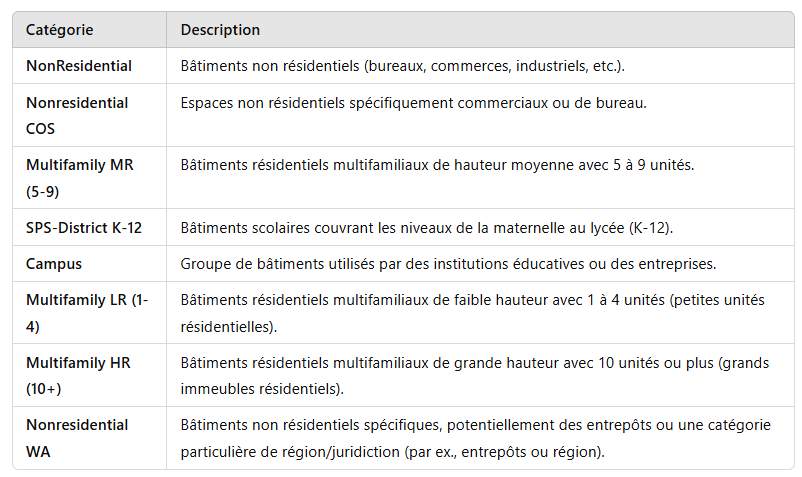

Pour le projet, nous allons donc retenir les catégories suivantes :
- NonResidential
- Nonresidential COS
- SPS-District K-12
- Campus
- Nonresidential WA

In [98]:
building_types = ['NonResidential', 'Nonresidential COS', 'SPS-District K-12', 'Campus', 'Nonresidential WA']

In [105]:
mask = data['BuildingType'].isin(building_types)
data = data.loc[mask]
data.shape

(1668, 46)

Il reste la moitié des bâtiments dans le dataset.

In [107]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1668 entries, 0 to 3375
Data columns (total 46 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   OSEBuildingID                    1668 non-null   int64  
 1   DataYear                         1668 non-null   int64  
 2   BuildingType                     1668 non-null   object 
 3   PrimaryPropertyType              1668 non-null   object 
 4   PropertyName                     1668 non-null   object 
 5   Address                          1668 non-null   object 
 6   City                             1668 non-null   object 
 7   State                            1668 non-null   object 
 8   ZipCode                          1652 non-null   float64
 9   TaxParcelIdentificationNumber    1668 non-null   object 
 10  CouncilDistrictCode              1668 non-null   int64  
 11  Neighborhood                     1668 non-null   object 
 12  Latitude                 